# poisson_solvers

> Various solvers for the Poisson problem

In [ ]:
#| default_exp poisson_solvers

# Problem

Solve $$\nabla^2\psi = - 2\pi^2\sin\pi x\sin\pi y \quad\text{in } 0\le x\le 1, 0 \le y \le 1,$$ with boundary condition $\psi = 0$ on $x = 0$ and $1$ and $y = 0$ and $1$.

The analytic solution is $$\psi = \sin\pi x\sin\pi y$$

# Imports

In [ ]:
# Autoreload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
import numpy as np
from scipy import sparse

In [ ]:
import matplotlib.pyplot as plt

from fastcore.test import test_eq, test_close

# Poisson solvers

## Gauss-Seidel solver

In [ ]:
#| export
def poisson_gauss_seidel_with_sor_solver(
    w, r=None,
    verbose=True, log_middle_values=False,
):
    N = w.shape[0] - 1
    nx = ny = N + 1

    h = 1 / N

    # Handle the SOR parameter
    if r is None:
        r = 2 / (1 + np.pi / N) # optimal value

    psi = np.zeros((nx, ny)) # streamfunction

    middle_values = []

    for iteration in range(1, 4 * nx + 1):
        for i in range(1, nx - 1):
            for j in range(1, ny - 1):
                psi[i, j] = (1 - r) * psi[i, j] + r * (
                    psi[i - 1, j] + psi[i + 1, j] +
                    psi[i, j - 1] + psi[i, j + 1] +
                    w[i, j] * h ** 2
                ) / 4
        
        if verbose:
            print(f"{iteration=}; psi(0.5, 0.5) = {psi[nx // 2, ny // 2]}")
        
        if log_middle_values:
            middle_values.append(psi[nx // 2, ny // 2])
    
    return psi, iteration, middle_values

In [ ]:
N = 20
nx = ny = N + 1

# Initialize grid and the value of the vorticity on it
x_grid, y_grid = np.meshgrid(
    np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij"
)
w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity

exact_solution = np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid)

In [ ]:
%%time
psi, iteration, _ = poisson_gauss_seidel_with_sor_solver(w)

iteration=1; psi(0.5, 0.5) = 0.11172552248786136
iteration=2; psi(0.5, 0.5) = 0.21474087386187146
iteration=3; psi(0.5, 0.5) = 0.3099755202444299
iteration=4; psi(0.5, 0.5) = 0.3978869625651614
iteration=5; psi(0.5, 0.5) = 0.4788019688123194
iteration=6; psi(0.5, 0.5) = 0.5529890863508751
iteration=7; psi(0.5, 0.5) = 0.6207061531268337
iteration=8; psi(0.5, 0.5) = 0.6822151831901546
iteration=9; psi(0.5, 0.5) = 0.7377909294427683
iteration=10; psi(0.5, 0.5) = 0.7877217669442479
iteration=11; psi(0.5, 0.5) = 0.8312664121411969
iteration=12; psi(0.5, 0.5) = 0.8675870198390819
iteration=13; psi(0.5, 0.5) = 0.8971068057797569
iteration=14; psi(0.5, 0.5) = 0.920747471978698
iteration=15; psi(0.5, 0.5) = 0.9394115200053935
iteration=16; psi(0.5, 0.5) = 0.9539354915518791
iteration=17; psi(0.5, 0.5) = 0.9650542801885681
iteration=18; psi(0.5, 0.5) = 0.9734062008490787
iteration=19; psi(0.5, 0.5) = 0.9795357489944586
iteration=20; psi(0.5, 0.5) = 0.983903832233904
iteration=21; psi(0.5, 0.5) =

In [ ]:
abs_err = (psi - exact_solution).max()
print(f"{iteration=}; {abs_err=}; psi(0.5, 0.5) = {psi[nx // 2, ny // 2]}")

iteration=84; abs_err=0.0020587065214789924; psi(0.5, 0.5) = 1.002058706521479


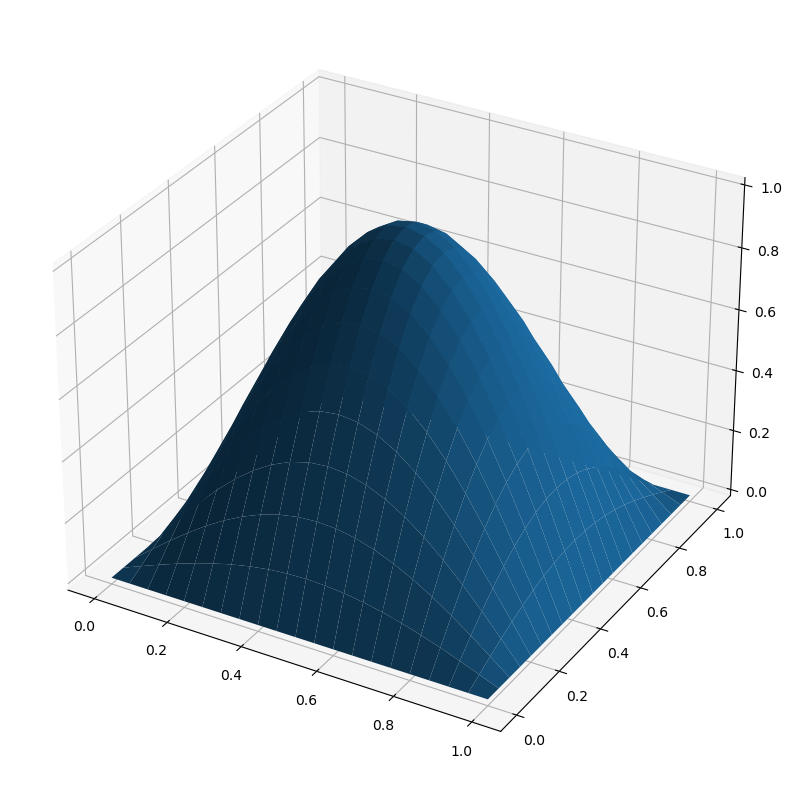

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# Plot the surface
ax.plot_surface(x_grid, y_grid, psi)

plt.show()

In [ ]:
y_grid[:, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [ ]:
x_grid[:5, :5], y_grid[:5, :5]

(array([[0.  , 0.  , 0.  , 0.  , 0.  ],
        [0.05, 0.05, 0.05, 0.05, 0.05],
        [0.1 , 0.1 , 0.1 , 0.1 , 0.1 ],
        [0.15, 0.15, 0.15, 0.15, 0.15],
        [0.2 , 0.2 , 0.2 , 0.2 , 0.2 ]]),
 array([[0.  , 0.05, 0.1 , 0.15, 0.2 ],
        [0.  , 0.05, 0.1 , 0.15, 0.2 ],
        [0.  , 0.05, 0.1 , 0.15, 0.2 ],
        [0.  , 0.05, 0.1 , 0.15, 0.2 ],
        [0.  , 0.05, 0.1 , 0.15, 0.2 ]]))

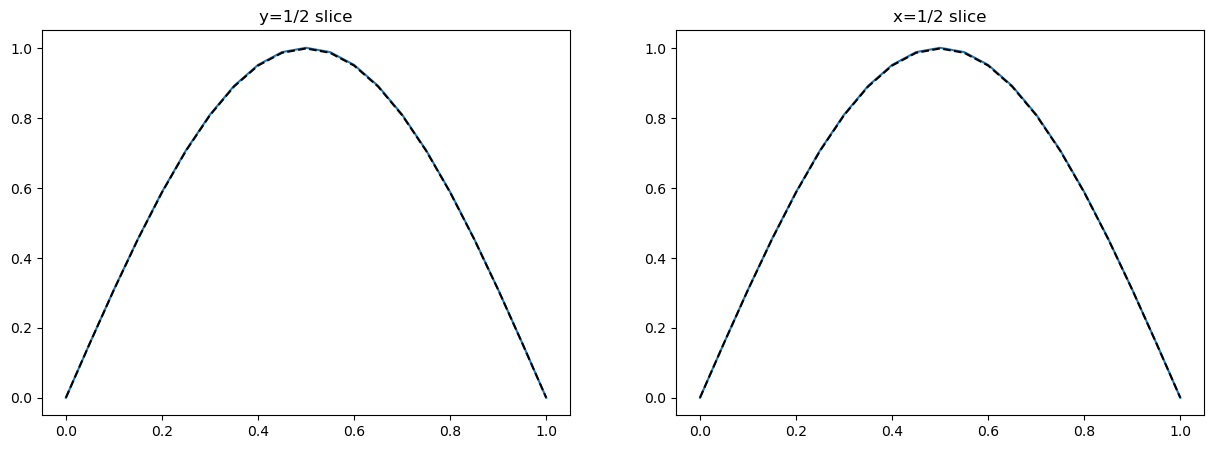

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the surface
ax1.plot(x_grid[:, 0], psi[:, ny // 2])
ax1.plot(x_grid[:, 0], np.sin(np.pi*x_grid[:, 0]), "--", color="black")
ax1.set_title("y=1/2 slice")

ax2.plot(y_grid[0, :], psi[nx // 2, :])
ax2.plot(y_grid[0, :], np.sin(np.pi*y_grid[0, :]), "--", color="black")
ax2.set_title("x=1/2 slice")

plt.show()

In [ ]:
max_location = np.unravel_index(psi.argmax(), psi.shape)
max_location, psi[max_location]

((10, 10), 1.002058706521479)

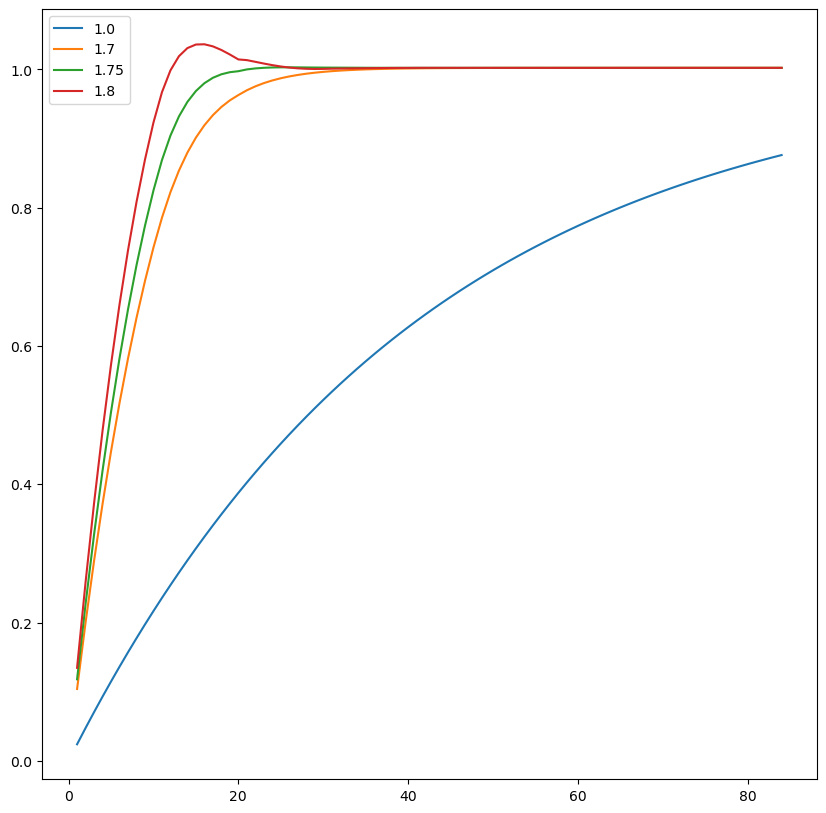

In [ ]:
plt.figure(figsize=(10, 10))

for r_value in [1.0, 1.7, 1.75, 1.8]:
    psi, _, middle_values = poisson_gauss_seidel_with_sor_solver(
        w, r=r_value, verbose=False, log_middle_values=True,
    )
    
    plt.plot(np.arange(1, 4 * nx + 1), middle_values, label=r_value)

plt.legend()
plt.show()    

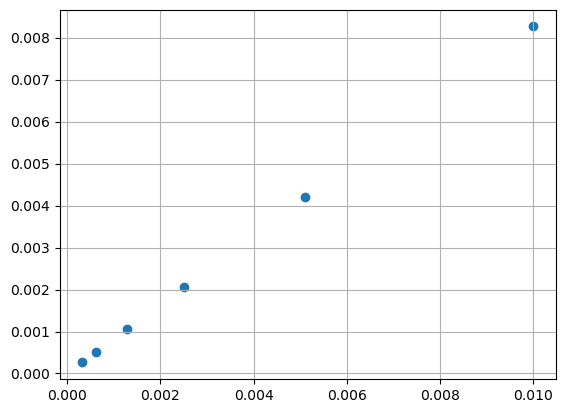

CPU times: user 2.15 s, sys: 54.1 ms, total: 2.2 s
Wall time: 3.4 s


In [ ]:
%%time
tmp = []
N_values = np.array([10, 14, 20, 28, 40, 56])
for N_value in N_values:
    nx = ny = N_value + 1

    # Initialize grid and the value of the vorticity on it
    x_grid, y_grid = np.meshgrid(
        np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij"
    )
    w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity

    exact_solution = np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid)
    
    psi, _, _ = poisson_gauss_seidel_with_sor_solver(w, verbose=False)

    abs_err = (psi - exact_solution).max()
    tmp.append(abs_err)
    
plt.scatter(1 / N_values ** 2, tmp)
plt.grid()
plt.show()    

In [ ]:
(slope, intercept), fit_errors = np.polyfit(1 / N_values ** 2, tmp, deg=1, cov=True)
print(f"Estimated slope is: {slope} +- {fit_errors[0, 0]}")

Estimated slope is: 0.8266454123824876 +- 2.784163824891643e-07


### Additional checks

#### Check no driving

First check $\psi = 0$ for $\omega = 0$:

In [ ]:
N = 20
nx = ny = N + 1

w = np.zeros_like(psi) # vorticity

In [ ]:
%%time
psi, _, _ = poisson_gauss_seidel_with_sor_solver(w)

test_eq(psi, np.array([0.0]))

iteration=1; psi(0.5, 0.5) = 0.0
iteration=2; psi(0.5, 0.5) = 0.0
iteration=3; psi(0.5, 0.5) = 0.0
iteration=4; psi(0.5, 0.5) = 0.0
iteration=5; psi(0.5, 0.5) = 0.0
iteration=6; psi(0.5, 0.5) = 0.0
iteration=7; psi(0.5, 0.5) = 0.0
iteration=8; psi(0.5, 0.5) = 0.0
iteration=9; psi(0.5, 0.5) = 0.0
iteration=10; psi(0.5, 0.5) = 0.0
iteration=11; psi(0.5, 0.5) = 0.0
iteration=12; psi(0.5, 0.5) = 0.0
iteration=13; psi(0.5, 0.5) = 0.0
iteration=14; psi(0.5, 0.5) = 0.0
iteration=15; psi(0.5, 0.5) = 0.0
iteration=16; psi(0.5, 0.5) = 0.0
iteration=17; psi(0.5, 0.5) = 0.0
iteration=18; psi(0.5, 0.5) = 0.0
iteration=19; psi(0.5, 0.5) = 0.0
iteration=20; psi(0.5, 0.5) = 0.0
iteration=21; psi(0.5, 0.5) = 0.0
iteration=22; psi(0.5, 0.5) = 0.0
iteration=23; psi(0.5, 0.5) = 0.0
iteration=24; psi(0.5, 0.5) = 0.0
iteration=25; psi(0.5, 0.5) = 0.0
iteration=26; psi(0.5, 0.5) = 0.0
iteration=27; psi(0.5, 0.5) = 0.0
iteration=28; psi(0.5, 0.5) = 0.0
iteration=29; psi(0.5, 0.5) = 0.0
iteration=30; psi(0.5, 

#### Check the sweeping direction

In [ ]:
N = 20
nx = ny = N + 1

h = 1 / N

# SOR parameter
r = 2 / (1 + np.pi / N) # optimal value

psi = np.zeros((nx, ny)) # streamfunction

# Initialize grid and the value of the vorticity on it
x_grid, y_grid = np.meshgrid(
    np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij"
)
w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity

exact_solution = np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid)


N_ITERATIONS = 4 * nx

for iteration in range(1, N_ITERATIONS + 1):
    for j in range(1, ny - 1):
        for i in range(1, nx - 1):
            psi[i, j] = (1 - r) * psi[i, j] + r * (
                psi[i - 1, j] + psi[i + 1, j] +
                psi[i, j - 1] + psi[i, j + 1] +
                w[i, j] * h ** 2
            ) / 4
    
    print(f"iteration={iteration}; psi(0.5, 0.5) = {psi[nx // 2, ny // 2]}")

iteration=1; psi(0.5, 0.5) = 0.11172552248786136
iteration=2; psi(0.5, 0.5) = 0.21474087386187146
iteration=3; psi(0.5, 0.5) = 0.3099755202444299
iteration=4; psi(0.5, 0.5) = 0.3978869625651614
iteration=5; psi(0.5, 0.5) = 0.4788019688123194
iteration=6; psi(0.5, 0.5) = 0.5529890863508751
iteration=7; psi(0.5, 0.5) = 0.6207061531268337
iteration=8; psi(0.5, 0.5) = 0.6822151831901546
iteration=9; psi(0.5, 0.5) = 0.7377909294427683
iteration=10; psi(0.5, 0.5) = 0.7877217669442479
iteration=11; psi(0.5, 0.5) = 0.8312664121411969
iteration=12; psi(0.5, 0.5) = 0.8675870198390819
iteration=13; psi(0.5, 0.5) = 0.8971068057797569
iteration=14; psi(0.5, 0.5) = 0.920747471978698
iteration=15; psi(0.5, 0.5) = 0.9394115200053935
iteration=16; psi(0.5, 0.5) = 0.9539354915518791
iteration=17; psi(0.5, 0.5) = 0.9650542801885681
iteration=18; psi(0.5, 0.5) = 0.9734062008490787
iteration=19; psi(0.5, 0.5) = 0.9795357489944586
iteration=20; psi(0.5, 0.5) = 0.983903832233904
iteration=21; psi(0.5, 0.5) =

In [ ]:
abs_err = (psi - exact_solution).max()
print(f"{iteration=}; {abs_err=}; psi(0.5, 0.5) = {psi[nx // 2, ny // 2]}")

iteration=84; abs_err=0.0020587065214789924; psi(0.5, 0.5) = 1.002058706521479


iteration=84; abs_err = 0.0020587065214785483; psi(0.5, 0.5) = 1.0020587065214785

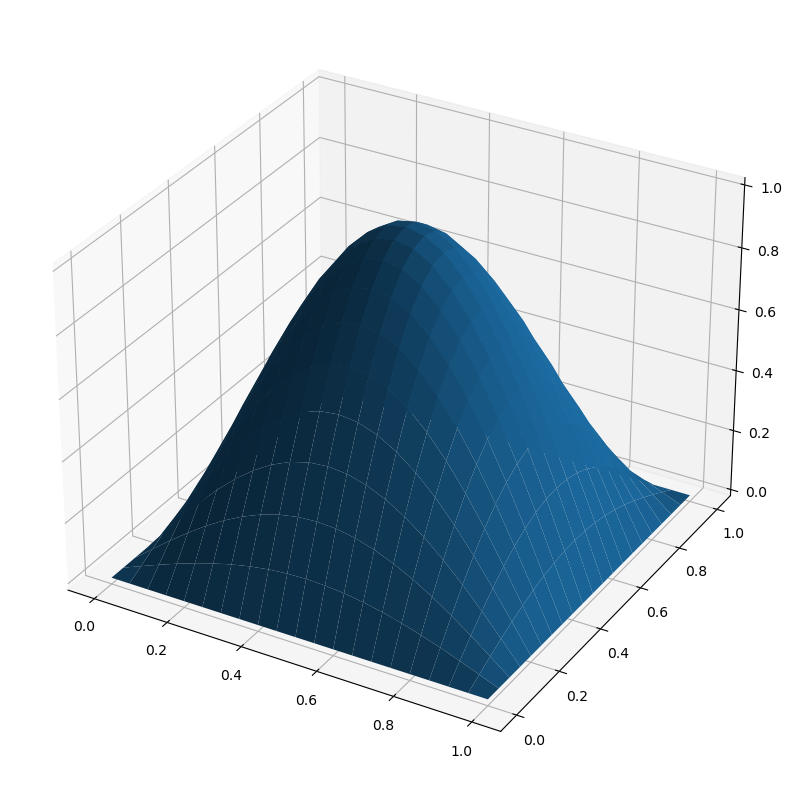

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# Plot the surface
ax.plot_surface(x_grid, y_grid, psi)

plt.show()

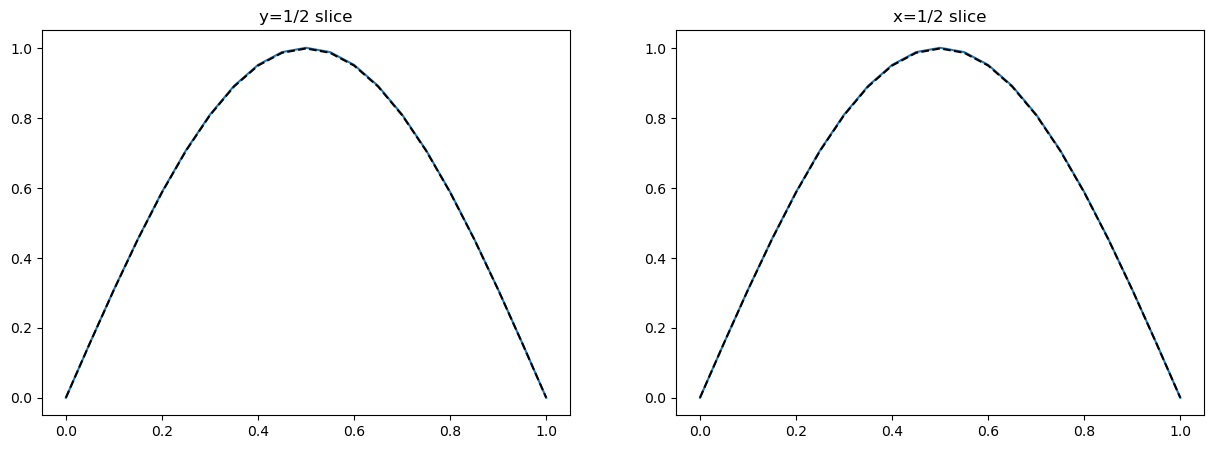

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the surface
ax1.plot(x_grid[:, 0], psi[:, ny // 2])
ax1.plot(x_grid[:, 0], np.sin(np.pi*x_grid[:, 0]), "--", color="black")
ax1.set_title("y=1/2 slice")

ax2.plot(y_grid[0, :], psi[nx // 2, :])
ax2.plot(y_grid[0, :], np.sin(np.pi*y_grid[0, :]), "--", color="black")
ax2.set_title("x=1/2 slice")

plt.show()

In [ ]:
max_location = np.unravel_index(psi.argmax(), psi.shape)
max_location, psi[max_location]

((10, 10), 1.002058706521479)

((10, 10), 1.0020587065214785)

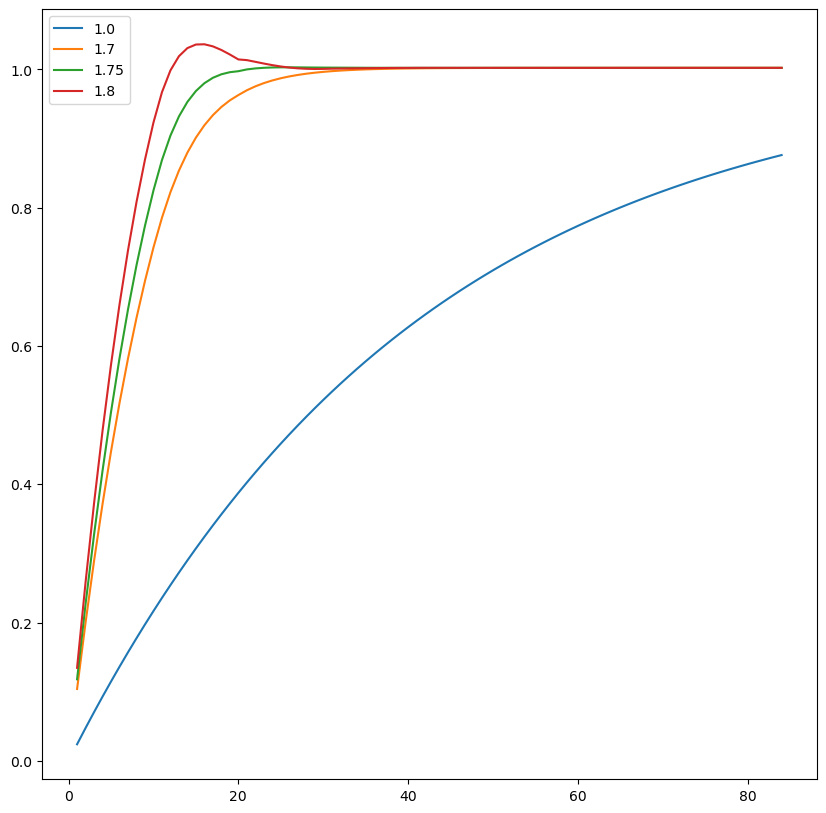

In [ ]:
plt.figure(figsize=(10, 10))

for r_value in [1.0, 1.7, 1.75, 1.8]:
    psi = np.zeros((nx, ny))
    tmp = []
    for iteration in range(1, N_ITERATIONS + 1):
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                psi[i, j] = (1 - r_value) * psi[i, j] + r_value * (
                    psi[i - 1, j] + psi[i + 1, j] +
                    psi[i, j - 1] + psi[i, j + 1] +
                    w[i, j] * h ** 2
                ) / 4
                
        tmp.append(psi[nx // 2, ny // 2])
    
    plt.plot(np.arange(1, N_ITERATIONS + 1), tmp, label=r_value)

plt.legend()
plt.show()    

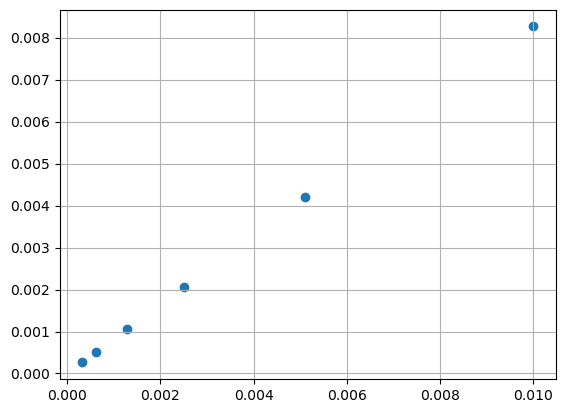

CPU times: user 2.37 s, sys: 35.6 ms, total: 2.4 s
Wall time: 2.71 s


In [ ]:
%%time
tmp = []
N_values = np.array([10, 14, 20, 28, 40, 56])
for N_value in N_values:
    nx = ny = N_value + 1

    h = 1 / N_value

    # SOR parameter
    r = 2 / (1 + np.pi / N_value) # optimal value

    psi = np.zeros((nx, ny)) # streamfunction

    # Initialize grid and the value of the vorticity on it
    x_grid, y_grid = np.meshgrid(
        np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij"
    )
    w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity

    exact_solution = np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid)
    
    num_iter = 4 * nx
    for iteration in range(1, num_iter + 1):
        for j in range(1, ny - 1):
            for i in range(1, nx - 1):
                psi[i, j] = (1 - r) * psi[i, j] + r * (
                    psi[i - 1, j] + psi[i + 1, j] +
                    psi[i, j - 1] + psi[i, j + 1] +
                    w[i, j] * h ** 2
                ) / 4
                
    
    abs_err = (psi - exact_solution).max()
    tmp.append(abs_err)
    
plt.scatter(1 / N_values ** 2, tmp)
plt.grid()
plt.show()    

In [ ]:
(slope, intercept), fit_errors = np.polyfit(1 / N_values ** 2, tmp, deg=1, cov=True)
print(f"Estimated slope is: {slope} +- {fit_errors[0, 0]}")

Estimated slope is: 0.8266454123824876 +- 2.784163824891643e-07


Estimated slope is: 0.8266454123824679 +- 2.78416382518097e-07

## SciPy solvers

In [ ]:
#| export
def construct_laplacian_kernel_matrix_dense(N):
    '''
    Construct the matrix that defines the linear system in dense form
    '''

    h = 1 / (N + 1)

    kernel_matrix = -4 * np.eye(N ** 2) / h ** 2
    index_matrix = np.arange(N ** 2).reshape((N, N))
    all_indices = np.arange(N ** 2)

    # Create grid
    x_grid, y_grid = np.meshgrid(
        np.arange(0, N), np.arange(0, N), indexing="ij"
    )

    # Masks for validity
    valid_above = x_grid > 0
    valid_below = x_grid < N - 1
    valid_left = y_grid > 0
    valid_right = y_grid < N - 1

    # Get the indices
    idx_above = index_matrix[(
        (x_grid - 1)[valid_above].flatten(), y_grid[valid_above].flatten()
    )]
    idx_below = index_matrix[(
        (x_grid + 1)[valid_below].flatten(), y_grid[valid_below].flatten()
    )]
    idx_left = index_matrix[(
        x_grid[valid_left].flatten(), (y_grid - 1)[valid_left].flatten()
    )]
    idx_right = index_matrix[(
        x_grid[valid_right].flatten(), (y_grid + 1)[valid_right].flatten()
    )]

    value = 1 / h ** 2
    kernel_matrix[all_indices[valid_above.flatten()], idx_above] = value
    kernel_matrix[all_indices[valid_below.flatten()], idx_below] = value
    kernel_matrix[all_indices[valid_left.flatten()], idx_left] = value
    kernel_matrix[all_indices[valid_right.flatten()], idx_right] = value

    return kernel_matrix


In [ ]:
#| export
def construct_laplacian_kernel_matrix_sparse(N):
    '''
    Construct the matrix that defines the linear system in sparse form
    '''

    h = 1 / (N + 1)

    index_matrix = np.arange(N ** 2).reshape((N, N))
    all_indices = np.arange(N ** 2)
    
    rows = [np.arange(N ** 2)]
    cols = [np.arange(N ** 2)]
    values = [[-4 / h ** 2] * N ** 2]

    # Create grid
    x_grid, y_grid = np.meshgrid(
        np.arange(0, N), np.arange(0, N), indexing="ij"
    )

    # Masks for validity
    valid_above = x_grid > 0
    valid_below = x_grid < N - 1
    valid_left = y_grid > 0
    valid_right = y_grid < N - 1

    # Get the indices
    rows.append(all_indices[valid_above.flatten()])
    cols.append(index_matrix[(
        (x_grid - 1)[valid_above].flatten(), y_grid[valid_above].flatten()
    )].flatten())
    values.append([1 / h ** 2] * (N ** 2 - N))

    rows.append(all_indices[valid_below.flatten()])
    cols.append(index_matrix[(
        (x_grid + 1)[valid_below].flatten(), y_grid[valid_below].flatten()
    )].flatten())
    values.append([1 / h ** 2] * (N ** 2 - N))

    rows.append(all_indices[valid_left.flatten()])
    cols.append(index_matrix[(
        x_grid[valid_left].flatten(), (y_grid - 1)[valid_left].flatten()
    )].flatten())
    values.append([1 / h ** 2] * (N ** 2 - N))

    rows.append(all_indices[valid_right.flatten()])
    cols.append(index_matrix[(
        x_grid[valid_right].flatten(), (y_grid + 1)[valid_right].flatten()
    )].flatten())
    values.append([1 / h ** 2] * (N ** 2 - N))

    # Flatten the lists
    rows = np.concatenate(rows)
    cols = np.concatenate(cols)
    values = np.concatenate(values)

    # Create the sparse matrix from the above information
    return sparse.csr_matrix((values, (rows, cols)), shape=(N ** 2, N ** 2))

In [ ]:
#| export
def poisson_non_iterative_solver(w, use_sparse=True):
    N = w.shape[0] - 2

    # Construct the matrix that defines the linear system
    if use_sparse:
        kernel_matrix = construct_laplacian_kernel_matrix_sparse(N)
    else:
        kernel_matrix = construct_laplacian_kernel_matrix_dense(N)
    
    # Cast vorticity to the required form
    w = -w[1:-1, 1:-1].flatten().reshape((N ** 2, 1))
    if use_sparse: w = sparse.csr_matrix(w)
    
    # Solve the linear system
    if use_sparse:
        psi = sparse.linalg.spsolve(kernel_matrix, w)
    else:
        psi = np.linalg.solve(kernel_matrix, w)
    
    psi = psi.reshape(N, N)

    psi = np.pad(psi, (1, 1), mode="constant")
    
    return psi


In [ ]:
# Initialize grid and the value of the vorticity on it
N = 20
nx = ny = N + 1
x_grid, y_grid = np.meshgrid(
    np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij"
)
w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity

# Solve the system
psi_1 = poisson_non_iterative_solver(w, use_sparse=False)
psi_2 = poisson_non_iterative_solver(w, use_sparse=True)
psi_3, _, _ = poisson_gauss_seidel_with_sor_solver(w, verbose=False)

test_close(psi_1, psi_2, eps=1e-8)
test_close(psi_1, psi_3, eps=1e-8)
test_close(psi_2, psi_2, eps=1e-8)

### Additional tests for the sparse solver

In [ ]:
%%time

# Initialize grid and the value of the vorticity on it
N = 100
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(
    np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij"
)
w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity

exact_solution = np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid)

# Solve the system
psi = poisson_non_iterative_solver(w)

CPU times: user 72.1 ms, sys: 8.34 ms, total: 80.4 ms
Wall time: 52.5 ms


In [ ]:
abs_err = np.abs(psi - exact_solution).max()
print(f"{abs_err=}; psi(0.5, 0.5) = {psi[nx // 2, ny // 2]}")

abs_err=8.225076215495619e-05; psi(0.5, 0.5) = 1.000082250762155


In [ ]:
test_close(psi, psi.T)

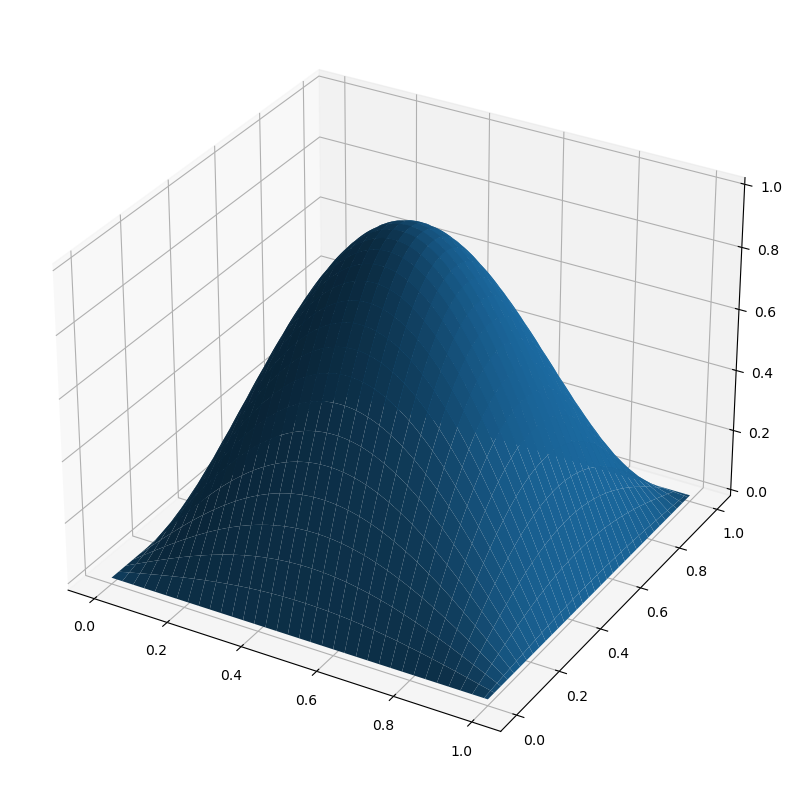

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

# Plot the surface
ax.plot_surface(x_grid, y_grid, psi)

plt.show()

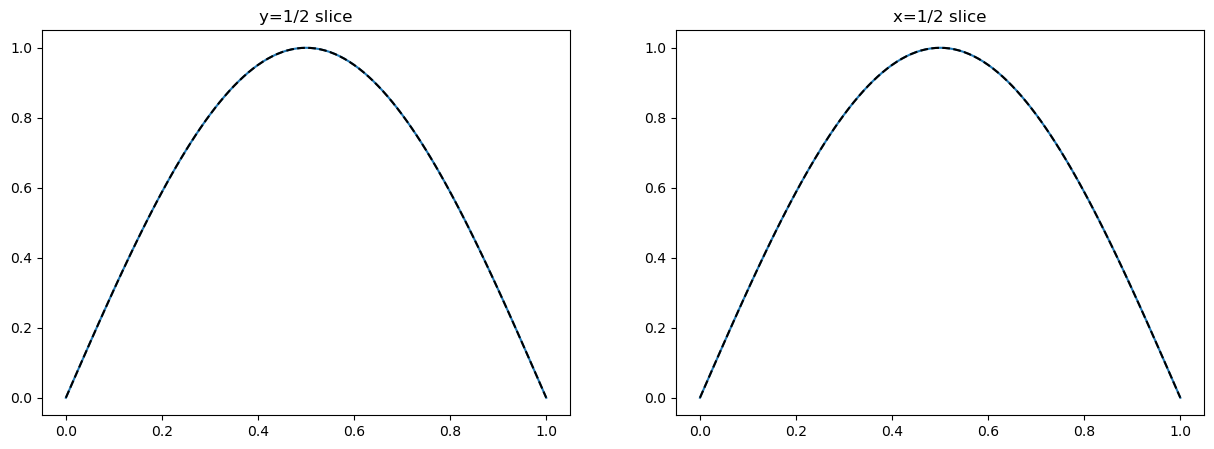

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot the surface
ax1.plot(x_grid[:, 0], psi[:, ny // 2])
ax1.plot(x_grid[:, 0], np.sin(np.pi*x_grid[:, 0]), "--", color="black")
ax1.set_title("y=1/2 slice")

ax2.plot(y_grid[0, :], psi[nx // 2, :])
ax2.plot(y_grid[0, :], np.sin(np.pi*y_grid[0, :]), "--", color="black")
ax2.set_title("x=1/2 slice")

plt.show()

In [ ]:
max_location = np.unravel_index(psi.argmax(), psi.shape)
max_location, psi[max_location]

((50, 50), 1.000082250762155)

In [ ]:
# Check the case w = 0 implies psi = 0

# Initialize grid and the value of the vorticity on it
N = 20
nx = ny = N + 1
h = 1 / N
x_grid, y_grid = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij")
w = np.zeros((nx, ny)) # vorticity

# Solve the system
psi_1 = poisson_non_iterative_solver(w, use_sparse=False)
psi_2 = poisson_non_iterative_solver(w, use_sparse=True)
psi_3, _, _ = poisson_gauss_seidel_with_sor_solver(w, verbose=False)

test_eq(np.any(psi_1), False)
test_eq(np.any(psi_2), False)
test_eq(np.any(psi_3), False)

# Export

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()